In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from collections import defaultdict
import seaborn as sns
from tqdm import tqdm
import matplotlib.patches as mpatches
from sklearn.cluster import DBSCAN
import scipy
import re
import scipy.fftpack
import itertools
from statsmodels.tsa.stattools import grangercausalitytests

import eye_metrics_utils
import data_utils
import gaze_entropy
import anova

In [2]:
import glob
csv_files = glob.glob("data/*.csv")
csv_files_one = [v for v in csv_files if "One Gaze-Vergence" in v]
csv_files_two = [v for v in csv_files if "Two Gaze-Vergence" in v]
csv_files_three = [v for v in csv_files if "Three Go-Around Gaze-Vergence" in v]

In [3]:
img = cv2.imread("flight.jpg")

overlay = img.copy()
thickness = -1

h,w,c = img.shape

In [4]:
roi_center = {
                "runway": (850, 170), 
                "rpmleft": (652, 438),
                "asi": (695, 490), 
                "alt": (820, 490),
                "nrst": (840, 550),
                "rpmright": (1050, 438),
             }

In [5]:
# modified ROIs
label = {"runway": [(0,0), (1280, 350), "r"],
         "rpmleft": [(633, 411), (672, 451), "r"],
         "asi": [(674, 432), (705, 525), "r"],
         "alt": [(797, 428), (852, 523), "r"],
         "hsi": [(742, 556), 45, "c"],
         "nrst": [(792, 534), (876, 554), "r"],
#          "RPM_RIGHT": [(1054, 440), 30, "c"]
}

encode_table = {
    "rpmleft": "P",
    "nrst": "Q",
#     "RPM_RIGHT": "R",
    "asi": "B",
    "hsi": "D",
    "alt": "E",
    "runway": "X",
    "unknown": "Z"
}

In [6]:
pdict = defaultdict()
for key in label:
    if label[key][-1] == "c":
        mask = np.zeros((h,w), np.uint8)
        cv2.circle(mask,label[key][0], label[key][1],255,-1)
        points = np.where(mask==255)
        pdict[key] = points
    elif label[key][-1] == "r":
        mask = np.zeros((h,w), np.uint8)
        cv2.rectangle(mask,label[key][0], label[key][1],255,-1)
        points = np.where(mask==255)
        pdict[key] = points

In [7]:
def distance(x, y):
    return ((x[0]-y[0])**2 + (x[1] - y[1])**2)**0.5

In [8]:
def calibration(df_fix, roi_center):
    diffx = []
    diffy = []
    idxmin= []
    for i in range(len(df_fix)):
        x = df_fix.iloc[i]
        m = np.argmin(x[-6:])
        idxmin.append(m)
        mx = list(roi_center.values())[m][0]
        my = list(roi_center.values())[m][1]

        if m == 0:
            w = 0.3
        else:
            w = 1
        diffx.append(w * (x.x - mx))
        diffy.append(w * (x.y - my))
    offsetx = np.mean(diffx)
    offsety = np.mean(diffy)
    print("offsetx", offsetx)
    print("offsety", offsety)
    
    return offsetx, offsety

In [9]:
def merge_consecutive_fixations_in_same_roi(df_fix):
    df_fix['value_grp'] = (df_fix.roi != df_fix.roi.shift()).cumsum()

    return pd.DataFrame({ 'start' : df_fix.groupby('value_grp').start.first(), 
                          'end' : df_fix.groupby('value_grp').end.last(),
                          'duration' : df_fix.groupby('value_grp').duration.sum(), 
                          'x' : df_fix.groupby('value_grp').x.mean(),
                          'y': df_fix.groupby('value_grp').y.mean(),
                          'roi': df_fix.groupby('value_grp').roi.first()
                         }).reset_index(drop=True)

In [10]:
def get_center(clustering, data):
    center = []
    for i in range(len(set(clustering.labels_)) - 1):
        xi = data[np.where(clustering.labels_ == i)]
        cx = sum(xi.T[0])/len(xi)
        cy = sum(xi.T[1])/len(xi)
        center.append((cx,cy))
    return center

In [11]:
def dist_func(point, v1, v2, type="c"): #between points and rectange/cirle
    """
    point: x, y
    v1,v2: topleft,bottomright if type = "r"
    v1,v2: center (x,y),  if type = "c"
    """    
    d = 0
    if type == "r":
        dx = max(v1[0] - point[0], 0, point[0] - v2[0])
        dy = max(v1[1] - point[1], 0, point[1] - v2[1])
        
        d = np.sqrt(dx*dx + dy*dy)
    elif type == "c":
        d = np.sqrt((point[0]-v1[0])**2 + (point[1]-v1[1])**2) - v2
        
    return d

In [12]:
def encode(lst_transition):
    str_transition = ""
    for v in lst_transition:
        str_transition = str_transition + encode_table[v]
    return str_transition

def decode(str_transition):
    lst_transition = []
    for v in str_transition:
        key_index = list(encode_table.values()).index(v)
        lst_transition.append(list(encode_table.keys())[key_index])
    return lst_transition

In [13]:
def run_one_data(filename):
    print(filename)
    df_data = pd.read_csv(filename)

    df_data = data_utils.reset_time(df_data)
    null_percent = data_utils.check_percentage_null(df_data)
    if null_percent > 0.2:
        print("null percent: {}, exclude ID {}".format(null_percent, filename[14:17]))
        return 0

    df_fixation = eye_metrics_utils.detect_fixations(df_data)
    df_blink = eye_metrics_utils.detect_blinks(df_data)
    df_saccade = eye_metrics_utils.detect_saccades(df_data)

    X = df_fixation[["x", "y"]].values
    clustering = DBSCAN(eps=20, min_samples=5, metric = distance).fit(X)
    df_fixation["roi"] = clustering.labels_
    df_fixation = merge_consecutive_fixations_in_same_roi(df_fixation)

    for k,v in roi_center.items():
        df_fixation["{}".format(k)] = df_fixation.apply(lambda x: distance(x[["x","y"]], v), axis=1)
        
        
    X = df_fixation[["x", "y"]].values
    clustering = DBSCAN(eps=20, min_samples=5, metric = distance).fit(X)

    color = clustering.labels_
    df_fixation["roi"] = clustering.labels_
        
#     img = plt.imread("flight.jpg")
#     h,w,c = img.shape
#     fig=plt.figure(figsize=(15,8))
#     ax=fig.add_axes([0,0,1,1])
#     # ax.imshow(img, extent=[0, 1600, 0, 900])
#     ax.imshow(img)
# #     ax.scatter(cluster_center[0], cluster_center[1], s=30, marker = "x", c = "red")
#     ax.scatter(X.T[0],X.T[1], c=color, cmap="jet", alpha = 0.5)

#     ax.set_xlabel('x')
#     ax.set_ylabel('y')
#     ax.set_title('center')

    offsetx, offsety = calibration(df_fixation, roi_center)
    df_fixation["x"] = df_fixation.x - offsetx
    df_fixation["y"] = df_fixation.y - offsety
    
    return df_fixation

In [14]:
def get_fixation_sequences(df_fixation, label = label, threshold = 20):
    roi = []
    count = 0
    for i in range(len(df_fixation)):
        x = df_fixation.iloc[i]
        point = (x.x, x.y)
        d = [dist_func(point, v[0], v[1], v[2]) for k,v in label.items()]
        order = np.argsort(d)
        if 0.0 not in d: # point is outside ROI
            if d[order[0]] > threshold:
                key = "unknown"
            else:
                key = list(pdict.keys())[order[0]]
        else:# point falls inside a ROI
            count += 1
            key = list(pdict.keys())[order[0]]
    #     print(d, order, key)
        roi.append(key)
    return roi

In [15]:
def create_transition_matrix(transitions):
    m = pd.crosstab(pd.Series(list(transitions)[1:], name = "t+1"),
            pd.Series(list(transitions)[:-1], name = "t"),normalize=1)
        
    return m

In [16]:
def create_transition_count_matrix(transitions):
    m = pd.crosstab(pd.Series(list(transitions)[1:], name = "t+1"),
            pd.Series(list(transitions)[:-1], name = "t"))
        
    return m

In [17]:
# print(create_transition_matrix(transitions))
# print(create_transition_count_matrix(transitions))

In [17]:
def encode_transition(transitions, label_type = "random"):
    """
    assign a random letter for each roi
    """
    letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
    L = list(set(transitions))
    print(L)
    enc_transitions = ""
    for roi in transitions:
        enc_transitions += letters[L.index(roi)]
        
    return enc_transitions, L

def decode_transitions(enc_transitions, list_labels):
    letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
    dec_transitions = []
    for enc_t in enc_transitions:
        dec_transitions.append(list_labels[letters.index(enc_t)])
        
    return dec_transitions

In [18]:
def find_all(p, s):
    '''Yields all the positions of
    the pattern p in the string s.'''
    i = s.find(p)
    while i != -1:
        yield i
        i = s.find(p, i+1)
        
list(find_all("BB", "BBBABBABBB"))

[0, 1, 4, 7, 8]

In [19]:
def find_index_of_most_subseq(enc_transition, L):
    '''
    enc_transitions: encoded transitions
    '''
    length = 2
    subseqcount = defaultdict(int)

    for i in range(len(enc_transitions)-length + 1):
        substring = enc_transitions[i:i+length]
        subseqcount[substring] += 1
    max_subseq = max(subseqcount, key=subseqcount.get)
    max5 = {k:subseqcount.get(k) for k in sorted(subseqcount, key=subseqcount.get, reverse=True)[:5]}
    print("max 5 subseq:", max5)
    print("max_subseq:", max_subseq)
    print("max_subseq decode:", decode_transitions(max_subseq, L))
    list_idx_max_subseq = list(find_all(max_subseq, enc_transitions))
    
    return list_idx_max_subseq

In [20]:
def merge_2roi_to_1roi(df_fixation, list_idx):
    df_data = df_fixation.copy()
    for idx in list_idx:
        df_x = df_data.loc[idx:idx + 1]
        start = df_x.iloc[0]["start"]
        end = df_x.iloc[1]["end"]
        duration = end - start
        x = df_x.iloc[0]["x"]
        y = df_x.iloc[0]["y"]
        roi = "{}_{}".format(df_x.iloc[0]['roi'], df_x.iloc[1]['roi'])
        
        df_data.loc[idx] = start, end, duration, x, y, roi
        if idx + 1 not in list_idx:
            df_data = df_data.drop(idx + 1)
        
    return df_data.reset_index(drop=True)

In [21]:
def construct_rect_signal(start, end, signal_end, sr = 1000):
    signal = np.zeros(int(signal_end*sr), dtype=int)
    for i, s in enumerate(start):
        s = int(start[i]*sr)
        e = int(end[i]*sr)
        signal[s:e] = 1
        
    return signal


def create_rect_signal_from_transitions(df_transition, sr = 1000):
    list_signals = {}
    signal_end = list(df_transition["end"])[-1]
    for roi in list(set(df_transition["roi"])):
        df_x = df_transition[df_transition["roi"] == roi]
        start = df_x['start'].values
        end = df_x['end'].values
        signal = construct_rect_signal(start, end, signal_end, sr)
        list_signals[roi] = signal
        
    return list_signals

In [22]:
def construct_spike_signal(start, signal_end, sr = 1000):
    signal = np.zeros(int(signal_end*sr), dtype=int)
    
    for i, s in enumerate(start):
        s = int(start[i]*sr)
        signal[s] = 1
        
    return signal

def create_spike_signal_from_transitions(df_transition, sr = 1000):
    list_signals = {}
    signal_end = list(df_transition["end"])[-1]
    for roi in list(set(df_transition["roi"])):
        df_x = df_transition[df_transition["roi"] == roi]
        start = df_x['start'].values
        signal = construct_spike_signal(start, signal_end, sr)
        list_signals[roi] = signal
        
    return list_signals

In [23]:
def fft(data_buffer, fps, low, high):   
    """
    calculate fft, return fft frequency in minute
    """
    L = len(data_buffer)
    freqs = float(fps) / L * np.arange(L / 2 + 1)
    freqs_in_minute = 60. * freqs
    raw_fft = np.fft.rfft(data_buffer)
    fft = np.abs(raw_fft)**2
    interest_idx = np.where((freqs_in_minute > low) & (freqs_in_minute < high))[0]
    interest_idx_sub = interest_idx[:-1].copy() #advoid the indexing error
    freqs_of_interest = freqs_in_minute[interest_idx_sub]
    fft_of_interest = fft[interest_idx_sub]
    
    return fft_of_interest, freqs_of_interest

In [25]:
df_fixation = run_one_data(csv_files_one[1])
roi = get_fixation_sequences(df_fixation)
df_fixation["roi"] = roi
df_fixation = merge_consecutive_fixations_in_same_roi(df_fixation)
transitions = df_fixation["roi"]

level = 0
num_max_subseq = 100
list_df_transition_merged = []
list_transitions = []
df_transition_merged = df_fixation.copy()
list_df_transition_merged.append(df_transition_merged)

while num_max_subseq > 3:
    print("level:",level)
    enc_transitions, L = encode_transition(transitions)
    print("enc_transitions:", enc_transitions)
    list_idx_max_subseq = find_index_of_most_subseq(enc_transitions, L)
    print(list_idx_max_subseq)
    num_max_subseq = len(list_idx_max_subseq)
    print("num_max_subseq:",num_max_subseq)
    df_transition_merged = merge_2roi_to_1roi(df_transition_merged, list_idx_max_subseq)
    list_df_transition_merged.append(df_transition_merged)
    transitions = df_transition_merged["roi"]
    list_transitions.append(transitions)
    level += 1
    print("------------------------------------------------------------")

data\PISSS_ID_002_Approach One Gaze-Vergence.csv
offsetx 9.27215261007028
offsety 1.9834836357279162
level: 0
['asi', 'unknown', 'hsi', 'nrst', 'alt', 'runway', 'rpmleft']
enc_transitions: FEFEFEFEFADEDFEFEFAEAGCDFGFEDEFEFEFEFEFAFDFEFECDGFGFGAFAEAFGACAFGAFEFAFAFEAFAFBEFEFAFAFAFEFAFAFDFEFAEFAGCDFEFEFAFEAFAGAFAFAEFAEFAEFAFEFAF
max 5 subseq: {'EF': 24, 'FE': 22, 'FA': 22, 'AF': 20, 'AE': 6}
max_subseq: EF
max_subseq decode: ['alt', 'runway']
[1, 3, 5, 7, 14, 16, 29, 31, 33, 35, 37, 43, 67, 79, 81, 89, 97, 100, 107, 109, 123, 126, 129, 133]
num_max_subseq: 24
------------------------------------------------------------
level: 1
['asi', 'alt_runway', 'unknown', 'hsi', 'nrst', 'alt', 'runway', 'rpmleft']
enc_transitions: GBBBBAEFEGBBAFAHDEGHGFEBBBBBAGEGBFDEHGHGHAGAFAGHADAGHAGBAGAGFAGAGCBBAGAGAGBAGAGEGBABAHDEGBBAGFAGAHAGAGABABABAGBAG
max 5 subseq: {'AG': 20, 'BA': 13, 'BB': 10, 'GA': 9, 'GB': 8}
max_subseq: AG
max_subseq decode: ['asi', 'runway']
[28, 41, 45, 50, 53, 56, 58, 61, 63, 68, 70, 7

In [122]:
df_transitions = list_df_transition_merged[1]
sr = 100
roi = "runway"

## Rect signal

In [123]:
rect_signals = create_rect_signal_from_transitions(df_transitions, sr)
rect_signals

{'asi': array([0, 0, 0, ..., 0, 0, 0]),
 'alt_runway': array([0, 0, 0, ..., 0, 0, 0]),
 'unknown': array([0, 0, 0, ..., 0, 0, 0]),
 'hsi': array([0, 0, 0, ..., 0, 0, 0]),
 'nrst': array([0, 0, 0, ..., 0, 0, 0]),
 'alt': array([0, 0, 0, ..., 0, 0, 0]),
 'runway': array([0, 0, 0, ..., 1, 1, 1]),
 'rpmleft': array([0, 0, 0, ..., 0, 0, 0])}

In [124]:
data = rect_signals[roi]
L = len(data)
end = df_transitions["end"].values[-1]
fps = float(L) / end
print(fps)
fft_of_interest, freqs_of_interest = fft(data, fps, 1, 60)

99.99423848474189


In [128]:
# s = np.fft.ifft(fft_of_interest)
# plt.plot(np.arange(len(s)), s.real, label='real')

Text(0.5, 0.98, 'roi: runway')

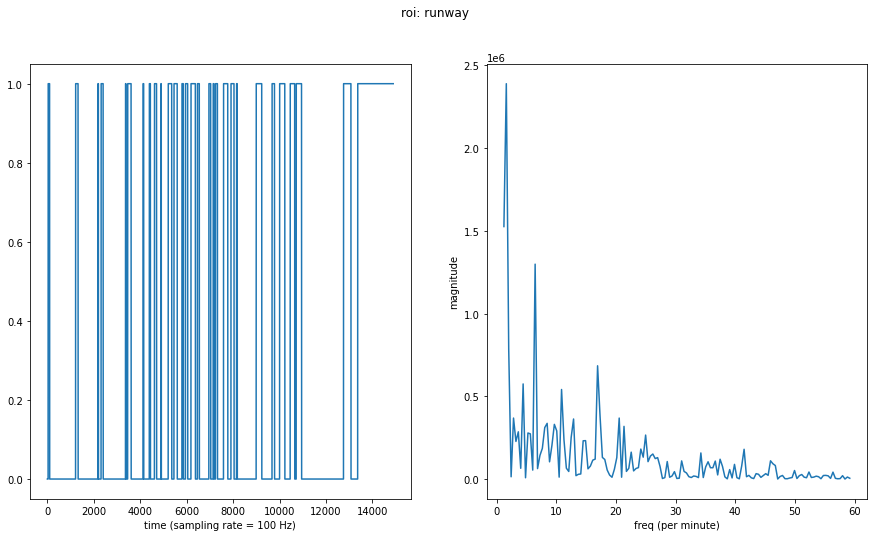

In [129]:
fig, axs = plt.subplots(ncols=2, figsize=(15,8))
axs[0].plot(data)
axs[0].set_xlabel(f"time (sampling rate = {sr} Hz)")

axs[1].plot(freqs_of_interest, fft_of_interest)
axs[1].set_ylabel("magnitude")
axs[1].set_xlabel("freq (per minute)")
fig.suptitle("roi: " + roi)

## Spike signal

In [130]:
spike_signals = create_spike_signal_from_transitions(df_transitions, sr)
spike_signals

{'asi': array([0, 0, 0, ..., 0, 0, 0]),
 'alt_runway': array([0, 0, 0, ..., 0, 0, 0]),
 'unknown': array([0, 0, 0, ..., 0, 0, 0]),
 'hsi': array([0, 0, 0, ..., 0, 0, 0]),
 'nrst': array([0, 0, 0, ..., 0, 0, 0]),
 'alt': array([0, 0, 0, ..., 0, 0, 0]),
 'runway': array([0, 0, 0, ..., 0, 0, 0]),
 'rpmleft': array([0, 0, 0, ..., 0, 0, 0])}

In [131]:
data = spike_signals[roi]
L = len(data)
end = df_transitions["end"].values[-1]
fps = float(L) / end
print(fps)
fft_of_interest, freqs_of_interest = fft(data, fps, 1, 60)

99.99423848474189


Text(0.5, 0.98, 'roi: runway')

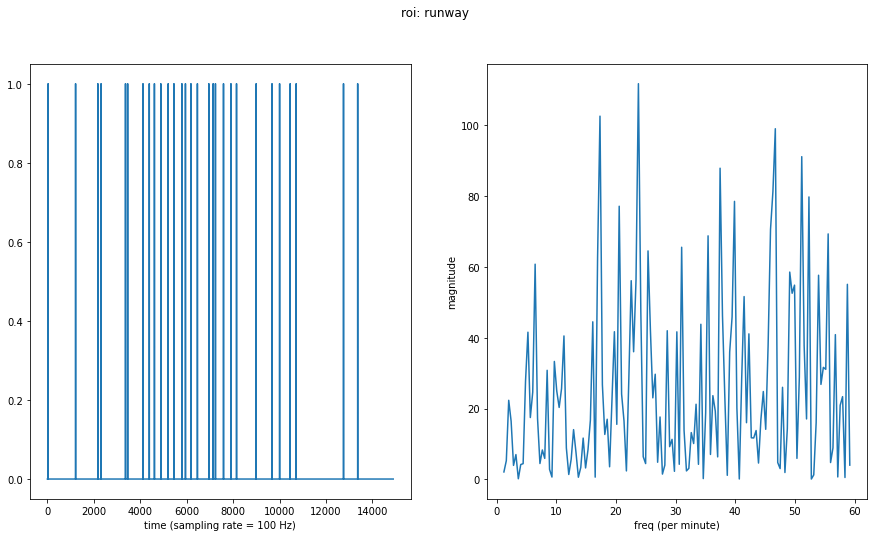

In [132]:
fig, axs = plt.subplots(ncols=2, figsize=(15,8))
axs[0].plot(data)
axs[0].set_xlabel(f"time (sampling rate = {sr} Hz)")

axs[1].plot(freqs_of_interest, fft_of_interest)
axs[1].set_ylabel("magnitude")
axs[1].set_xlabel("freq (per minute)")
fig.suptitle("roi: " + roi)

In [133]:
rois = list(rect_signals.keys())
rois

['asi', 'alt_runway', 'unknown', 'hsi', 'nrst', 'alt', 'runway', 'rpmleft']

In [134]:
list_perm = list(itertools.permutations(rois, 2))

In [135]:
list(list_perm[0])

['asi', 'alt_runway']

In [136]:
df_granger = pd.DataFrame(columns = ["roi1", "roi2", "lag", "pval"])
for perm in list_perm:
    data = pd.DataFrame(rect_signals)[list(perm)]
    maxlag = 4
    x = grangercausalitytests(data, maxlag=maxlag, verbose=False)
    lroi1 = [perm[0]] * maxlag
    lroi2 = [perm[1]] * maxlag
    llag = np.arange(maxlag)
    lpval = []
    for i in range(1, maxlag + 1):
        p_val = x[i][0]["ssr_ftest"][1]
        lpval.append(p_val)
        
    df_x = pd.DataFrame({"roi1": lroi1,
                        "roi2": lroi2,
                        "lag": llag,
                        "pval": lpval})
    df_granger = pd.concat([df_granger, df_x], ignore_index=True)
    

In [137]:
df_granger[df_granger["pval"] < 0.05]

,roi1,roi2,lag,pval
0,asi,alt_runway,0,2.531064e-03
1,asi,alt_runway,1,8.885822e-03
2,asi,alt_runway,2,2.041777e-02
3,asi,alt_runway,3,3.788120e-02
11,asi,hsi,3,3.251193e-06
20,asi,runway,0,2.813612e-03
21,asi,runway,1,9.796148e-03
22,asi,runway,2,2.233576e-02
23,asi,runway,3,4.114197e-02
48,alt_runway,runway,0,6.753500e-05


In [138]:
data = pd.DataFrame(rect_signals)
a = grangercausalitytests(data, maxlag=4)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3134  , p=0.1283  , df_denom=14894, df_num=1
ssr based chi2 test:   chi2=2.3139  , p=0.1282  , df=1
likelihood ratio test: chi2=2.3137  , p=0.1282  , df=1
parameter F test:         F=2.3134  , p=0.1283  , df_denom=14894, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1841  , p=0.3061  , df_denom=14891, df_num=2
ssr based chi2 test:   chi2=2.3690  , p=0.3059  , df=2
likelihood ratio test: chi2=2.3688  , p=0.3059  , df=2
parameter F test:         F=1.1841  , p=0.3061  , df_denom=14891, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8083  , p=0.4891  , df_denom=14888, df_num=3
ssr based chi2 test:   chi2=2.4259  , p=0.4888  , df=3
likelihood ratio test: chi2=2.4257  , p=0.4889  , df=3
parameter F test:         F=0.8083  , p=0.4891  , df_denom=14888, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6208  

0.6476410843913205

In [102]:
a[4][0]

{'ssr_ftest': (0.4773009498078963, 0.7524529720624914, 14885.0, 4),
 'ssr_chi2test': (1.910358171700049, 0.7522419290622152, 4),
 'lrtest': (1.9102356674848124, 0.7522644390993285, 4),
 'params_ftest': (0.47730094981428645, 0.7524529720576315, 14885.0, 4.0)}

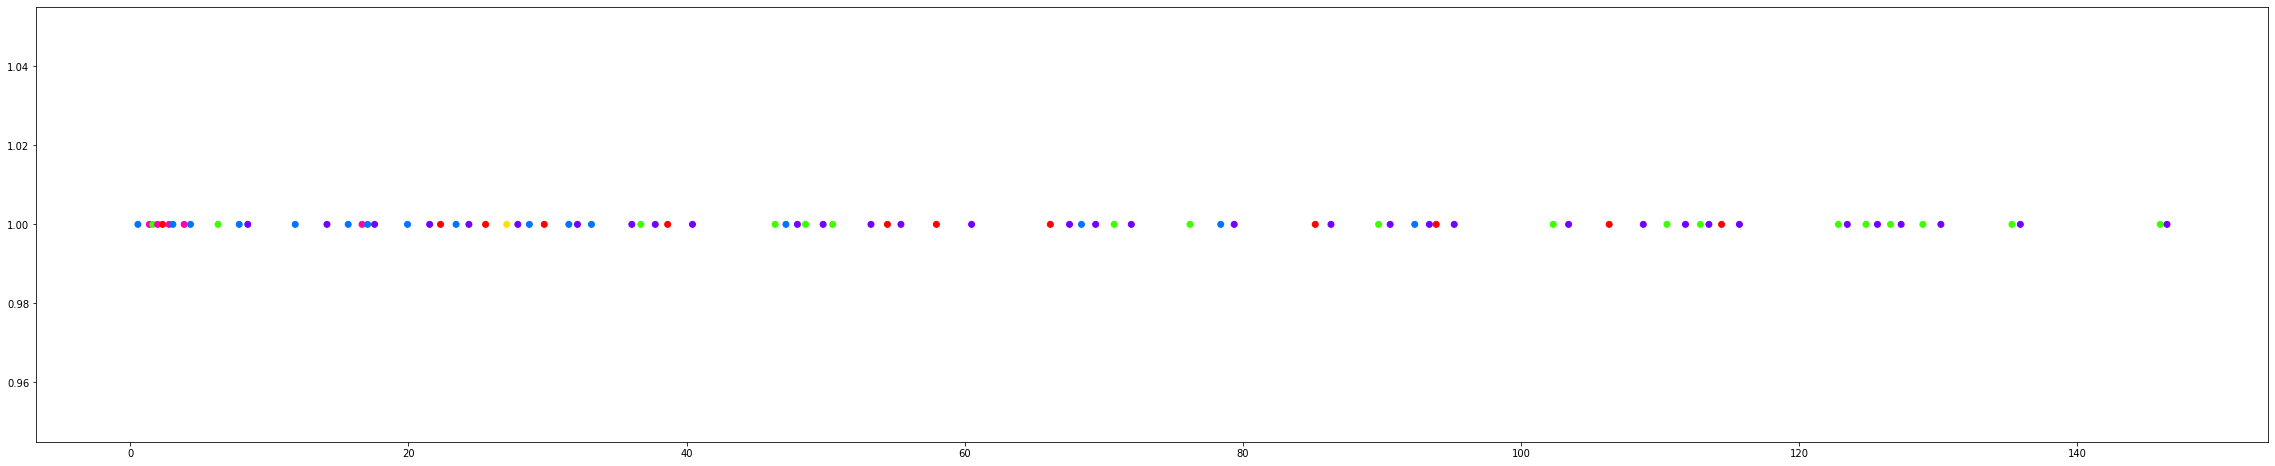

In [31]:
# colors = plt.get_cmap('RdYlGn')(np.linspace(0, 1, 6))
colors = plt.get_cmap('hsv')(np.linspace(0, 0.9, 7))

color_codes = {
    "rpmleft": colors[0],
    "nrst": colors[1],
    "asi": colors[2],
    "hsi": colors[3],
    "alt": colors[4],
    "runway": colors[5],
    "unknown": colors[6],
}

# equal width
fig, ax = plt.subplots(figsize=(40, 8))
x = df_fixation["start"]
y = [1] * len(x)
cols = [color_codes[v] for v in df_fixation['roi']]
ax.scatter(x, y, c=cols)
